In [1]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


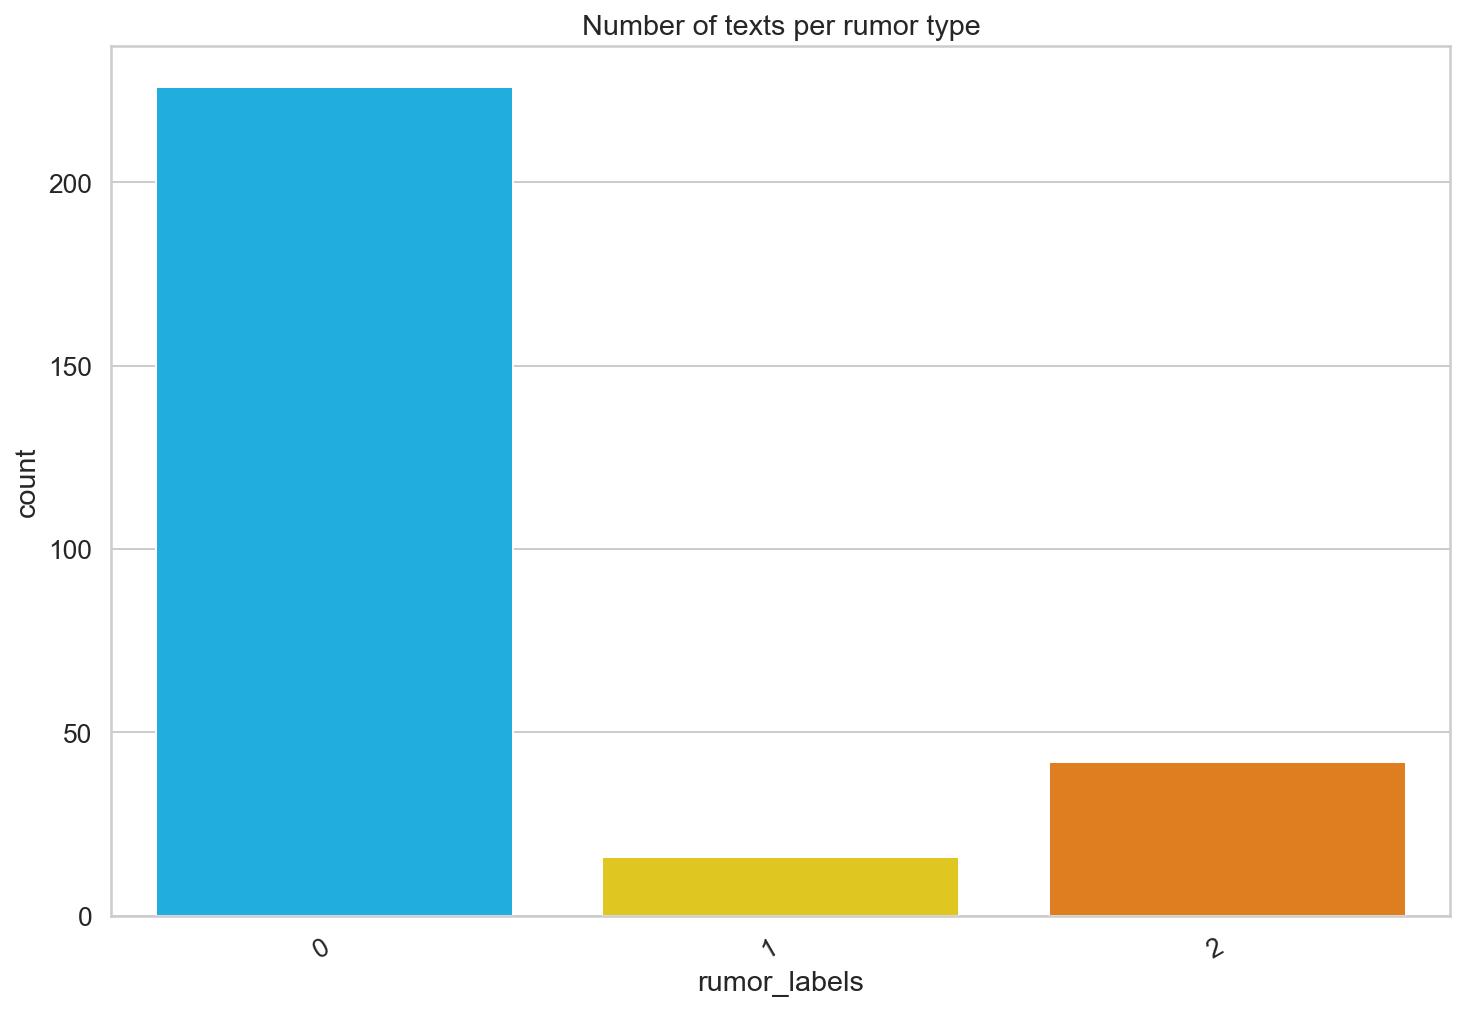

In [6]:
df= pd.read_csv('./data/DXYRumors.csv')
df['rumor_data'] = df['title']+df['mainSummary']+df['body']
df= df.drop(["id","_id","summary","sourceUrl","crawlTime","title","mainSummary","summary","body"], axis=1)
# rename columns 
df.columns = ['rumor_labels', 'rumor_data']
df.head()

#train = pd.read_csv("./data/train.csv")
#valid = pd.read_csv("./data/valid.csv")
#test = pd.read_csv("./data/test.csv")

#train = train.append(valid).reset_index(drop=True)
#print(train.shape)
#train.head()
chart = sns.countplot(df.rumor_labels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per rumor type")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [7]:
os.makedirs("model", exist_ok=True)
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [8]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [9]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [11]:
def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model

In [12]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)
print(data.train_x.shape)
print(data.train_x[0])

print(data.train_y[0])
print(data.max_seq_len)

13784it [00:08, 1637.63it/s]
700it [00:00, 1514.30it/s]


max seq_len 38
(13784, 38)
[ 101 2377 3769  102    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
0
38


In [13]:
model = create_model(data.max_seq_len, bert_ckpt_file)
model.summary()

model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12\bert_model.ckpt into <bert.model.BertModelLayer object at 0x00000208D956F248> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)       

In [ ]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

In [16]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

ValueError: Invalid format string